In [64]:
# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime

# feature transformation and preprocessing
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# to save Machine Learning Models
import pickle

# visualization of results
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

# LIME to explain predictions
import lime 
import lime.lime_tabular

In [2]:
train = pd.read_csv("raw/train.csv")
test = pd.read_csv("raw/test.csv")

# Clean Data

In [3]:
def CleanData(df):
    # this function drops not used columns
    # and duplicate rows
    # and empty rows of target(poinst)
    # returns cleaned df

    drop_columns = ["designation",
                    "winery",
                    "region_2",
                    "taster_twitter_handle"]
    interim_df = df.drop(columns=drop_columns)

    interim_df_2 = interim_df.drop_duplicates(ignore_index=True)
    
    cleaned_df = (interim_df_2
                  .dropna(subset=["points"], 
                          how="any")
                  .reset_index(drop=True))
    
    return cleaned_df

In [4]:
train_cleaned = CleanData(train)
test_cleaned = CleanData(test)

In [5]:
#train.info()

In [6]:
#train_cleaned.info()

# Feature Extraction

In [7]:
# description
def extract_features_from_description(df, 
                                      new_feature_name, 
                                      extract_words):
    # function to extract features from the descripiton
    # searches description feature for a given list
    # ASSUMPTION: There is no NA values exists
    # in the description feature
    check_regex = (r'\b(?:{})\b'
                   .format('|'
                           .join(
                               map(re.escape,
                                   extract_words))))

    df[new_feature_name] = (df['description']
                            .str
                            .contains(check_regex,
                                      regex=True)
                            .astype('uint8'))
    return df

In [8]:
# title
def extract_year_from_title(title):
    # function to find the year in the given list
    # if not found assigns zero as year
    # ASSUMPTION: There is no NA values exists
    # in the title feature
    
    int_list = []
    now = datetime.datetime.now()
    
    for item in title:
        int_list.append(int(item))
    
    for item in int_list:
        if item <= now.year and item >= 1900:
            return item
        else:
            return 0

In [9]:
# variety
def extract_blend_from_variety(variety):
    # function to find if a variety is a blend
    # ASSUMPTION: There is no NA values exists
    # in the variety feature
    
    if (variety.find("-") != -1) | (variety.find("Blend") != -1):
        if variety == "Xarel-lo":
            return 0
        else:
            return 1
    else:
        return 0

In [10]:
is_red_list = ["red", "Red", "RED",
               "noir", "NOIR", "Noir",
               "black", "BLACK", "Black"]

is_white_list = ["white", "WHITE", "White",
                 "blanc", "Blanc", "BLANC",
                 "bianco", "Bianco", "BIANCO",
                 "blanco", "Blanco", "BLANCO",
                 "blanca", "Blanca", "BLANCA"]

is_rose_list = ["rose", "ROSE", "Rose",
                "rosé", "Rosé", "ROSÉ"]

is_sparkling_list = ["sparkling", "SPARKLING", "Sparkling"]

is_dry_list = ["dry", "Dry", "DRY",
               "dried", "Dried", "DRIED"]

is_sweet_list = ["sweet", "Sweet", "SWEET"]

desc_extracting_dict = {
    "is_red": is_red_list,
    "is_white": is_white_list,
    "is_rose": is_rose_list,
    "is_sparkling": is_sparkling_list,
    "is_dry": is_dry_list,
    "is_sweet": is_sweet_list
}

In [11]:
def ExtractFeatures(df):
    # adds is_red, is_white, is_rose, is_rose
    # is_sparkling, is_dry, is_sweet
    for key, value in desc_extracting_dict.items():
        interim_df = extract_features_from_description(
            df, key, value)

    # adds year
    interim_df["title_numlist"] = (interim_df
                                   .title
                                   .str
                                   .findall(r'\b\d+\b'))

    interim_df["year"] = (interim_df
                          .title_numlist
                          .apply(extract_year_from_title))

    # adds is_blend
    interim_df["is_blend"] = (interim_df
                              .variety
                              .apply(extract_blend_from_variety))

    features_added_df = (interim_df
                         .drop(columns=["description",
                                        "title",
                                        "title_numlist"]))
    return features_added_df

In [12]:
train_features_added = ExtractFeatures(train_cleaned)
test_features_added = ExtractFeatures(test_cleaned)

In [13]:
# test_features_added.info()

In [14]:
# train_features_added.info()

In [15]:
# test_cleaned.info()

# Categorical Value Transformation

In [16]:
ordinal_encode_cols = ["country", "province",
                       "region_1", "taster_name", "variety"]

In [17]:
def EncodeCategoricalData(train_df, test_df, cols=ordinal_encode_cols):
    # funtion to create ordinal encoder object and
    # assigns -1 to the unseen labels of the test set
    # returns ordinal encoded train and test datasets
    # respectively
    ordinal_encoder = OrdinalEncoder(cols=ordinal_encode_cols,
                                     return_df=True,
                                     handle_unknown="value",
                                     handle_missing="return_nan")
    ordinal_encoder.fit(train_df)
    
    ord_encoded_train = (ordinal_encoder
                         .transform(train_df))
    
    ord_encoded_test = (ordinal_encoder
                        .transform(test_df))

    return ord_encoded_train, ord_encoded_test

In [18]:
data_encoded = EncodeCategoricalData(train_features_added, 
                                      test_features_added)
train_encoded = data_encoded[0]
test_encoded = data_encoded[1]

In [19]:
# train_encoded.info()

In [20]:
# test_encoded.info()

In [21]:
#train_encoded.country.mode()

In [22]:
#train_encoded.province.mode()

In [23]:
#train_encoded.region_1.mode()

In [24]:
#train_encoded.variety.mode()

In [25]:
#train_encoded.price.median()

In [26]:
#train_encoded.year.median()

In [27]:
#train_encoded.info()

In [28]:
#test_encoded.info()

# Impute Missing Values

In [29]:
def ImputeWithConstant(train_df, test_df, cols=["taster_name"]):
    # function to impute taster_name
    # with 0 stands for "Unknown value"

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols])

    constant_imputer = SimpleImputer(strategy="constant",
                                     fill_value=0)

    constant_imputer.fit(train_df)
    
    imputed_train_set = constant_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = constant_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [30]:
def ImputeWithMedian(train_df, test_df, cols=["price", "year"]):
    # function to impute price and year
    # columns with the median value of each 
    # median imputer is fitted on train dataset
    # transformation done on the train and test set

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols]) 
    
    median_imputer = SimpleImputer(strategy="median")

    median_imputer.fit(train_df)
    
    imputed_train_set = median_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = median_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [31]:
def ImputeWithMostFrequent(train_df, test_df, 
                           cols=["country", "province", "region_1", "variety"]):
    # function to impute country, province, region_1, variety
    # columns with the most_frequent value of each feature
    # most_frequent imputer is fitted on train dataset
    # transformation done on the train and test set

    train_df = pd.DataFrame(train_df[cols])
    test_df = pd.DataFrame(test_df[cols]) 
    
    most_frequent_imputer = SimpleImputer(strategy="most_frequent")

    most_frequent_imputer.fit(train_df)
    
    imputed_train_set = most_frequent_imputer.transform(train_df)
    imputed_train_df = pd.DataFrame(imputed_train_set,
                                    columns=train_df.columns)

    imputed_test_set = most_frequent_imputer.transform(test_df)
    imputed_test_df = pd.DataFrame(imputed_test_set,
                                   columns=test_df.columns)

    return imputed_train_df, imputed_test_df

In [32]:
def ImputeMissingValues(train_df, test_df):
    # separete non-NA cols
    is_features = [col for col in train_df.columns if col.find("is_") != -1]
    interim_train_1 = train_df[is_features]
    interim_test_1 = test_df[is_features]

    # impute taster_name NA with 0 as "Unknown"
    constant_impute = ImputeWithConstant(train_df,
                                         test_df)
    interim_train_2 = constant_impute[0]
    interim_test_2 = constant_impute[1]

    # impute year and price with median
    median_impute = ImputeWithMedian(train_df,
                                     test_df)
    interim_train_3 = median_impute[0]
    interim_test_3 = median_impute[1]

    # impute country, province, region_1,
    # variety with most_frequent
    most_frequent_impute = ImputeWithMostFrequent(train_df,
                                                  test_df)
    interim_train_4 = most_frequent_impute[0]
    interim_test_4 = most_frequent_impute[1]

    train_features = (interim_train_4
                      .join(interim_train_3)
                      .join(interim_train_2)
                      .join(interim_train_1))
    train_target = pd.DataFrame(
        train_df["points"])

    test_features = (interim_test_4
                     .join(interim_test_3)
                     .join(interim_test_2)
                     .join(interim_test_1))
    test_target = pd.DataFrame(
        test_df["points"])

    return train_features, train_target, test_features, test_target

In [33]:
transformed_data = ImputeMissingValues(train_encoded,
                                       test_encoded)

train_features = transformed_data[0]
train_target = transformed_data[1]
test_features = transformed_data[2]
test_target = transformed_data[3]

In [34]:
# train_features

In [35]:
# train_features.isna().any()

In [36]:
# train_features.index

In [37]:
# test_features

In [38]:
# test_features.index

In [39]:
# test_features.isna().any()

In [40]:
# train_target

In [41]:
# train_target.index

In [42]:
# test_target

In [43]:
# test_target.index

# Train Model

In [44]:
def convert_features_to_array(features):
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    target_array = np.array(target).reshape((-1, ))
    return target_array

In [45]:
model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                              max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                              max_samples=None, min_impurity_decrease=0.0,
                              min_impurity_split=None, min_samples_leaf=2,
                              min_samples_split=6, min_weight_fraction_leaf=0.0,
                              n_estimators=300, n_jobs=None, oob_score=False,
                              random_state=42, verbose=0, warm_start=False)

X = convert_features_to_array(train_features)
y = convert_target_to_array(train_target)

In [46]:
def TrainModel(model, X, y):
    model.fit(X, y)
    filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [47]:
TrainModel(model, X, y)

# Evaluate Model

In [48]:
def fit_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return mean_squared_error(y_test, y_predicted)

In [49]:
X_test = convert_features_to_array(test_features)
y_test = convert_target_to_array(test_target)

loaded_model = pickle.load(open('model.sav', 'rb'))
predictions = loaded_model.predict(test_features)

In [50]:
%%time
mse_rf = fit_evaluate_model(loaded_model, 
                            X, 
                            y, 
                            X_test, 
                            y_test)

print("MSE of Random Forests", mse_rf)

MSE of Random Forests 4.923805287200021
CPU times: user 1.96 s, sys: 39.3 ms, total: 2 s
Wall time: 2.02 s


**Plot Prediction and Actuals Distribution**

In [84]:
def PlotPredictedVSActual(predictions, actuals):

    # distribution of the points according to country
    figsize(20, 10)
    plt.rcParams['font.size'] = 14
    # plt.rcParams['axes.axisbelow'] = True

    # histogram of predictions
    ax = plt.subplot(121)
    ax.hist(predictions,
            bins=10, 
            color="#971539")
    ax.set_xlabel("points", size=14)
    ax.set_xticks(range(80, 101))
    ax.set_ylabel("count", size=14)
    ax.set_title("Predicted Distribution", size=16)
    ax.grid(zorder=0)

    # histogram of actual values
    ax2 = plt.subplot(122)
    ax2.hist(actuals,
             bins=20, 
             color="#971539")
    ax2.set_xlabel("points", size=14)
    ax2.set_xticks(range(80, 101))
    ax2.set_ylabel("count", size=14)
    ax2.set_title("Actual Distribution", size=16)
    ax2.grid(zorder=0)

    plt.savefig("PredictionsVSActuals.png")

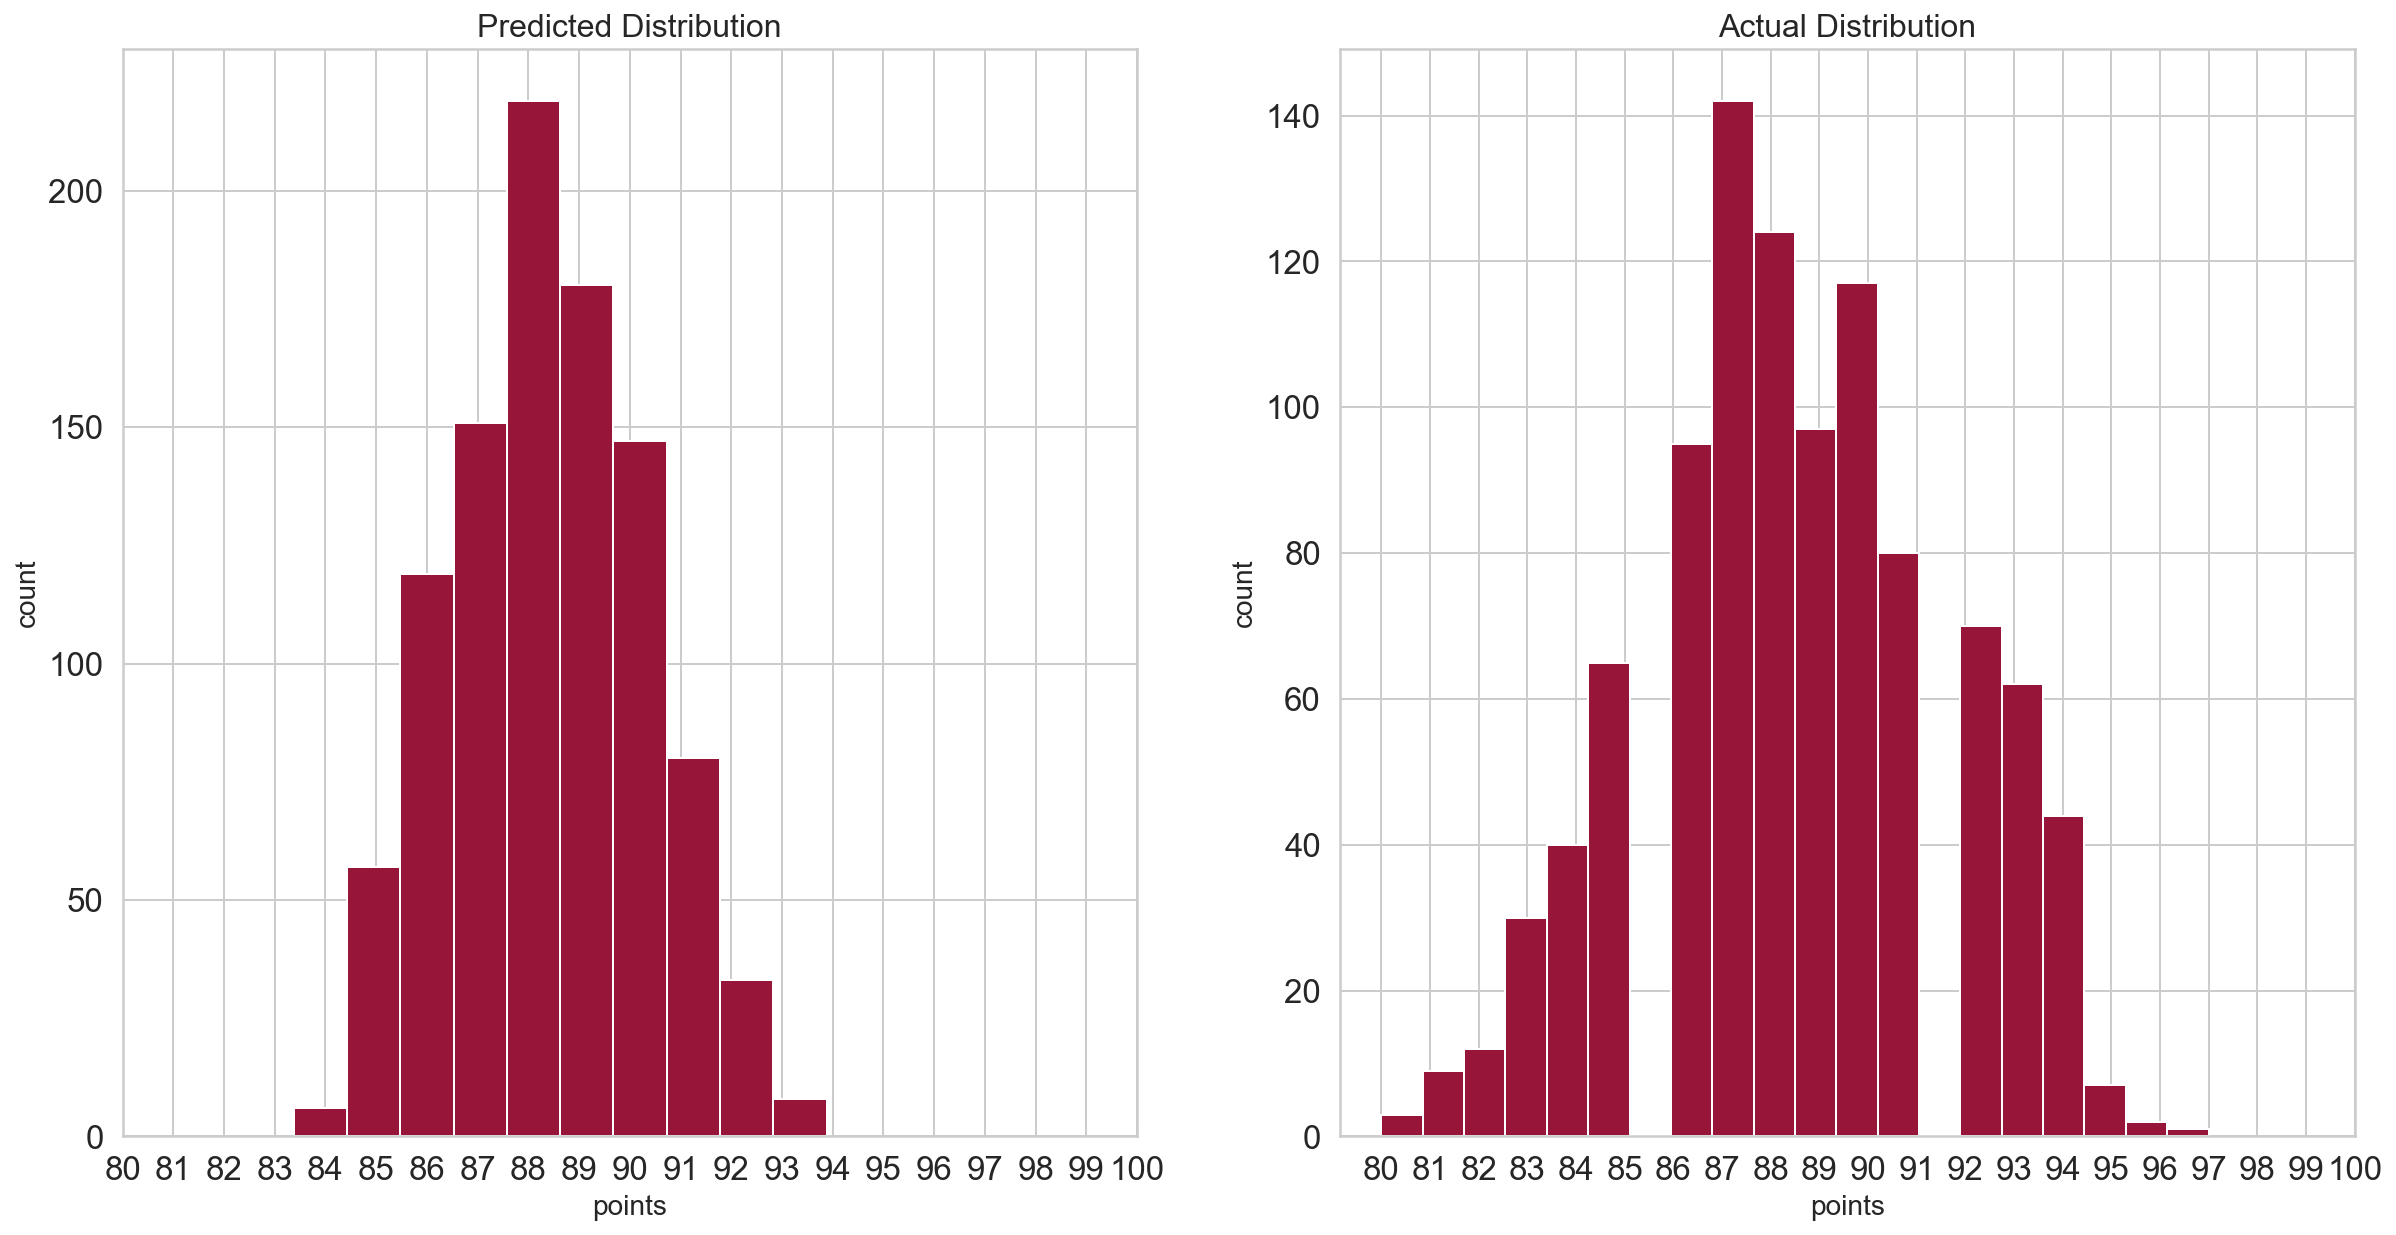

In [85]:
PlotPredictedVSActual(predictions, y_test)

**Plot feature importances**

In [86]:
def PlotFeatureImportances(model, feature_names):
    feature_importances = (pd
                           .DataFrame(
                               {'feature': feature_names,
                                'importance': model
                                .feature_importances_}))

    feature_importances = (feature_importances
                           .sort_values(by="importance",
                                        ascending=False))
    # figsize(20, 10)
    # plt.rcParams['font.size'] = 14

    # plt.bar(feature_importances["feature"], 
    #        feature_importances["importance"])

    # plt.xticks(rotation=60)
    # plt.xlabel("feature", size=14)
    # plt.ylabel("relative importance", size=14)
    # plt.title("Feature Importances", size=16)
    # plt.savefig("FeatureImportances.png")
    
    

    # prepare plot
    plt.figure(figsize=(20,10))
    sns.set(font_scale=1.5, style="whitegrid")

    # set color
    labels = np.array(feature_importances.feature)
    values = np.array(feature_importances.importance) 
    colors = ["#808080" if (y < max(values))
              else "#971539" for y in values]

    # set the plot
    ax = sns.barplot(x="importance", 
                     y="feature", 
                     data=feature_importances, 
                     palette = colors)
    ax.grid(zorder=0)

    # set title and arrange x,y ticks
    plt.title("Feature Importances")
    #for item in ax.get_xticklabels():
        #item.set_rotation(90)

In [62]:
feature_names = list(test_features.columns)

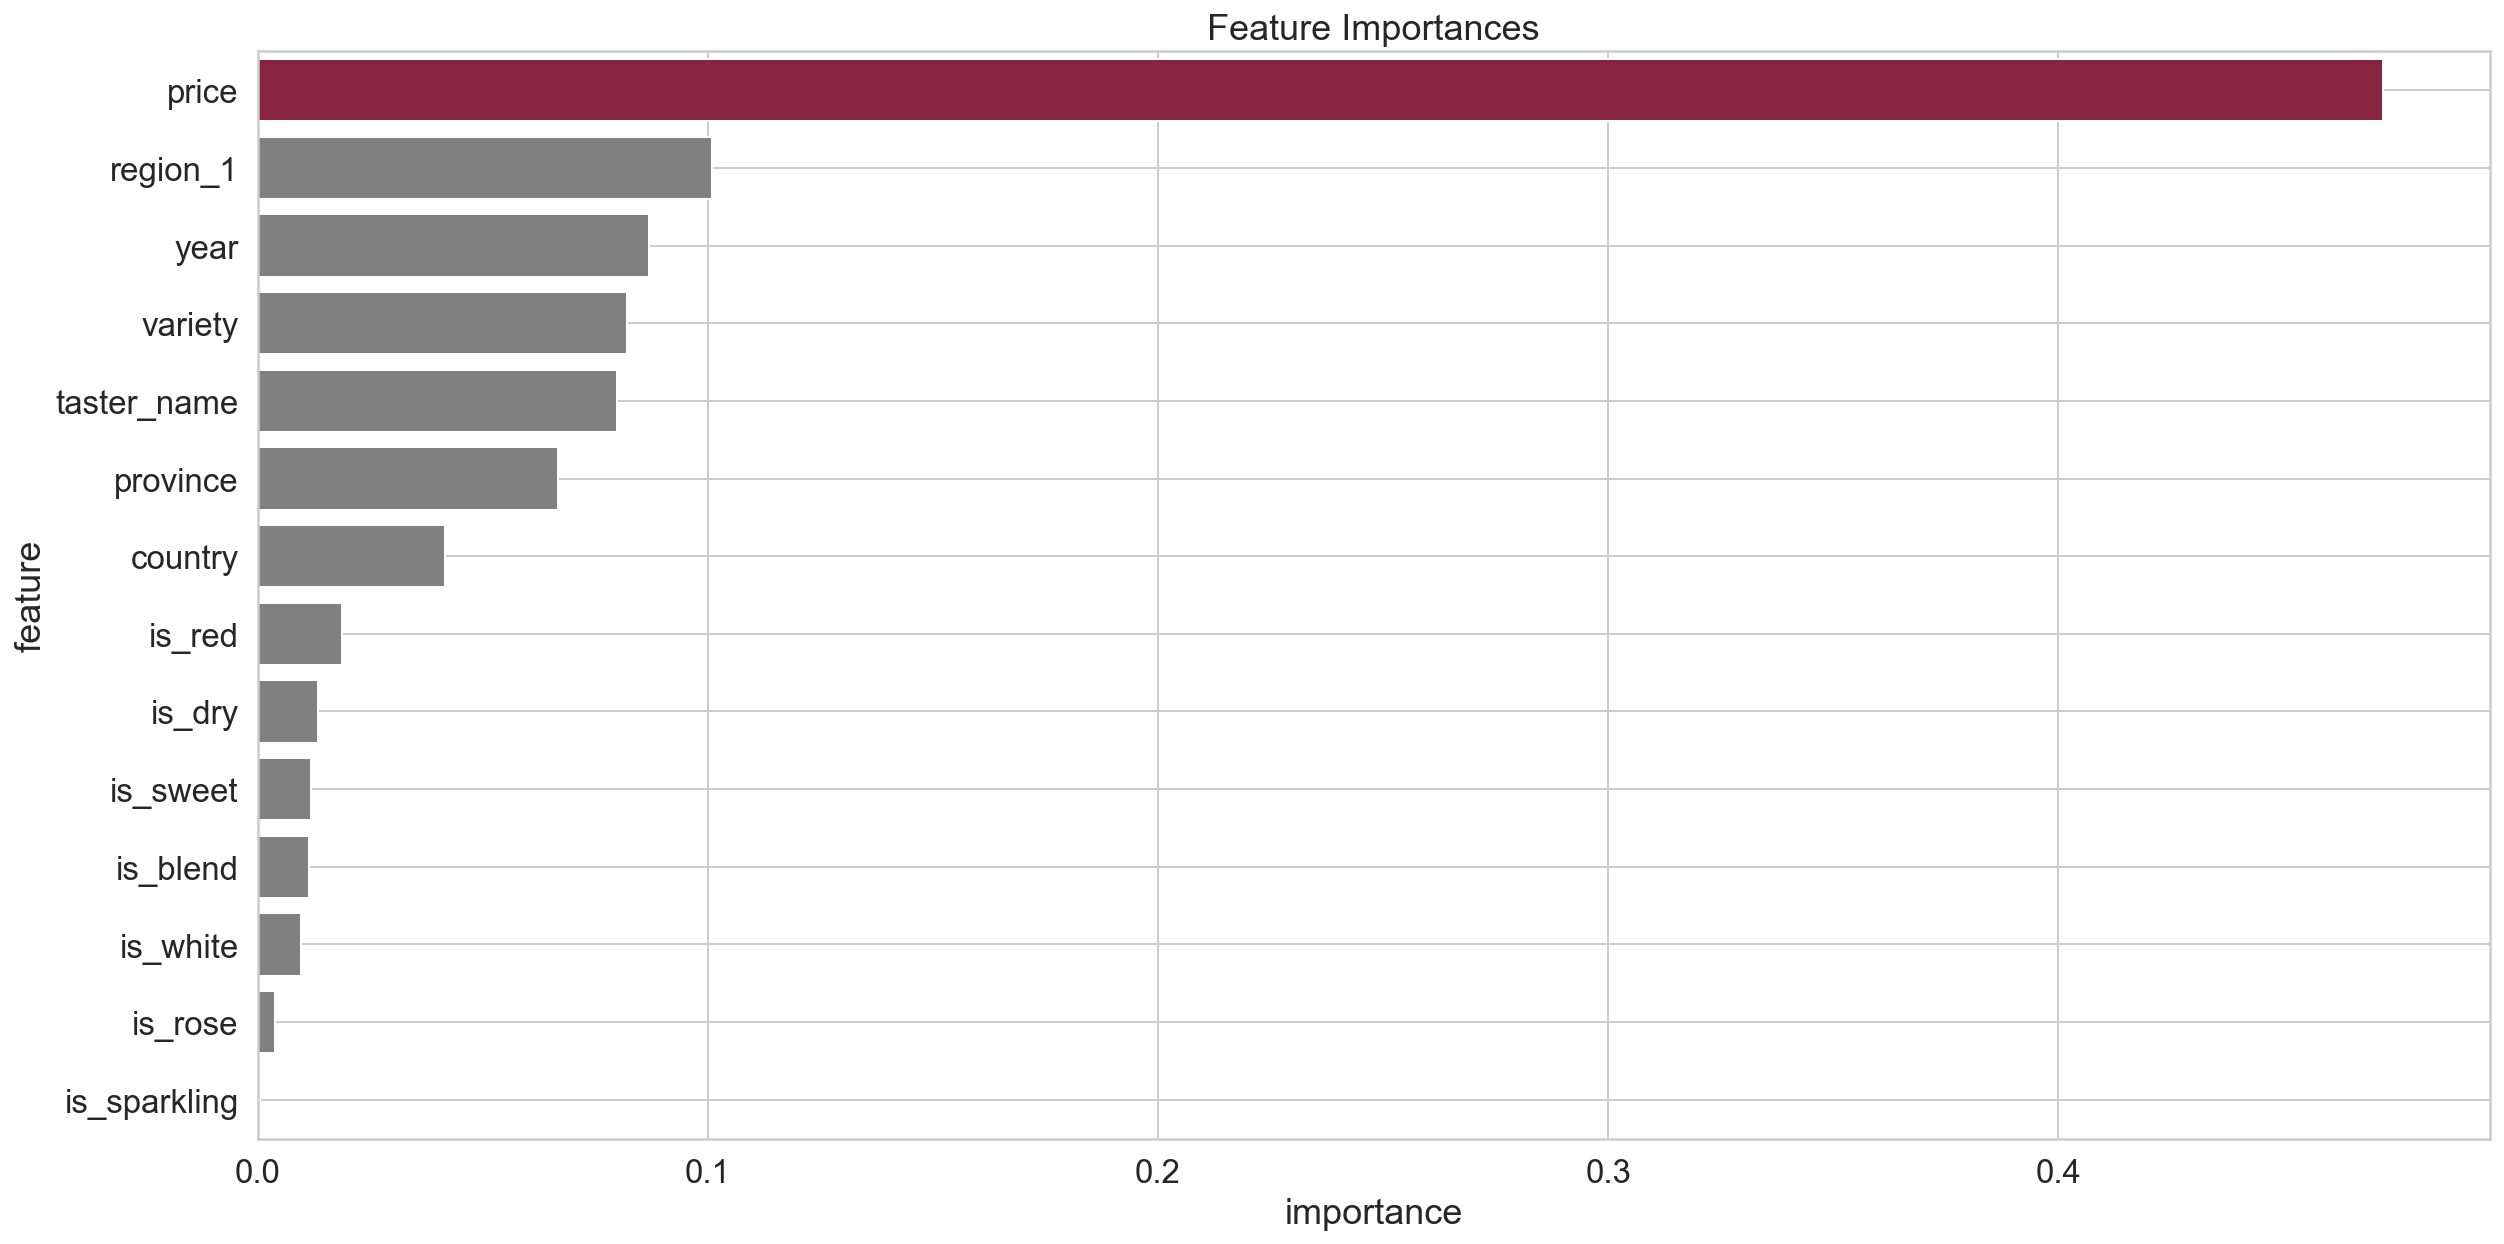

In [87]:
PlotFeatureImportances(loaded_model, feature_names)

**Plot individual predictions**

In [88]:
def PlotIndividualPrediction(model, individual_y_value,
                             difference_array, y_test, 
                             png_name):

    print('Prediction: {}'
          .format(model.predict(individual_y_value.reshape(1, -1))))
    print('Actual Value: {}'
          .format(y_test[np.argmax(difference_array)]))

    # Explanation for wrong prediction
    exp = (explainer
           .explain_instance(data_row=individual_y_value,
                             predict_fn=model.predict))

    # Plot the prediction explaination
    figsize(20, 10)
    plt.rcParams['font.size'] = 14

    exp.as_pyplot_figure()
    plt.title('Explanation of Prediction', size=16)
    plt.xlabel('Effect on Prediction', size=14)
    plt.savefig(png_name)

In [89]:
# find the residuals
residuals = abs(predictions - y_test)

# Exact the worst and best prediction
wrong = X_test[np.argmax(residuals), :]
right = X_test[np.argmin(residuals), :]

# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = feature_names)

Prediction: [90.60839957]
Actual Value: 82


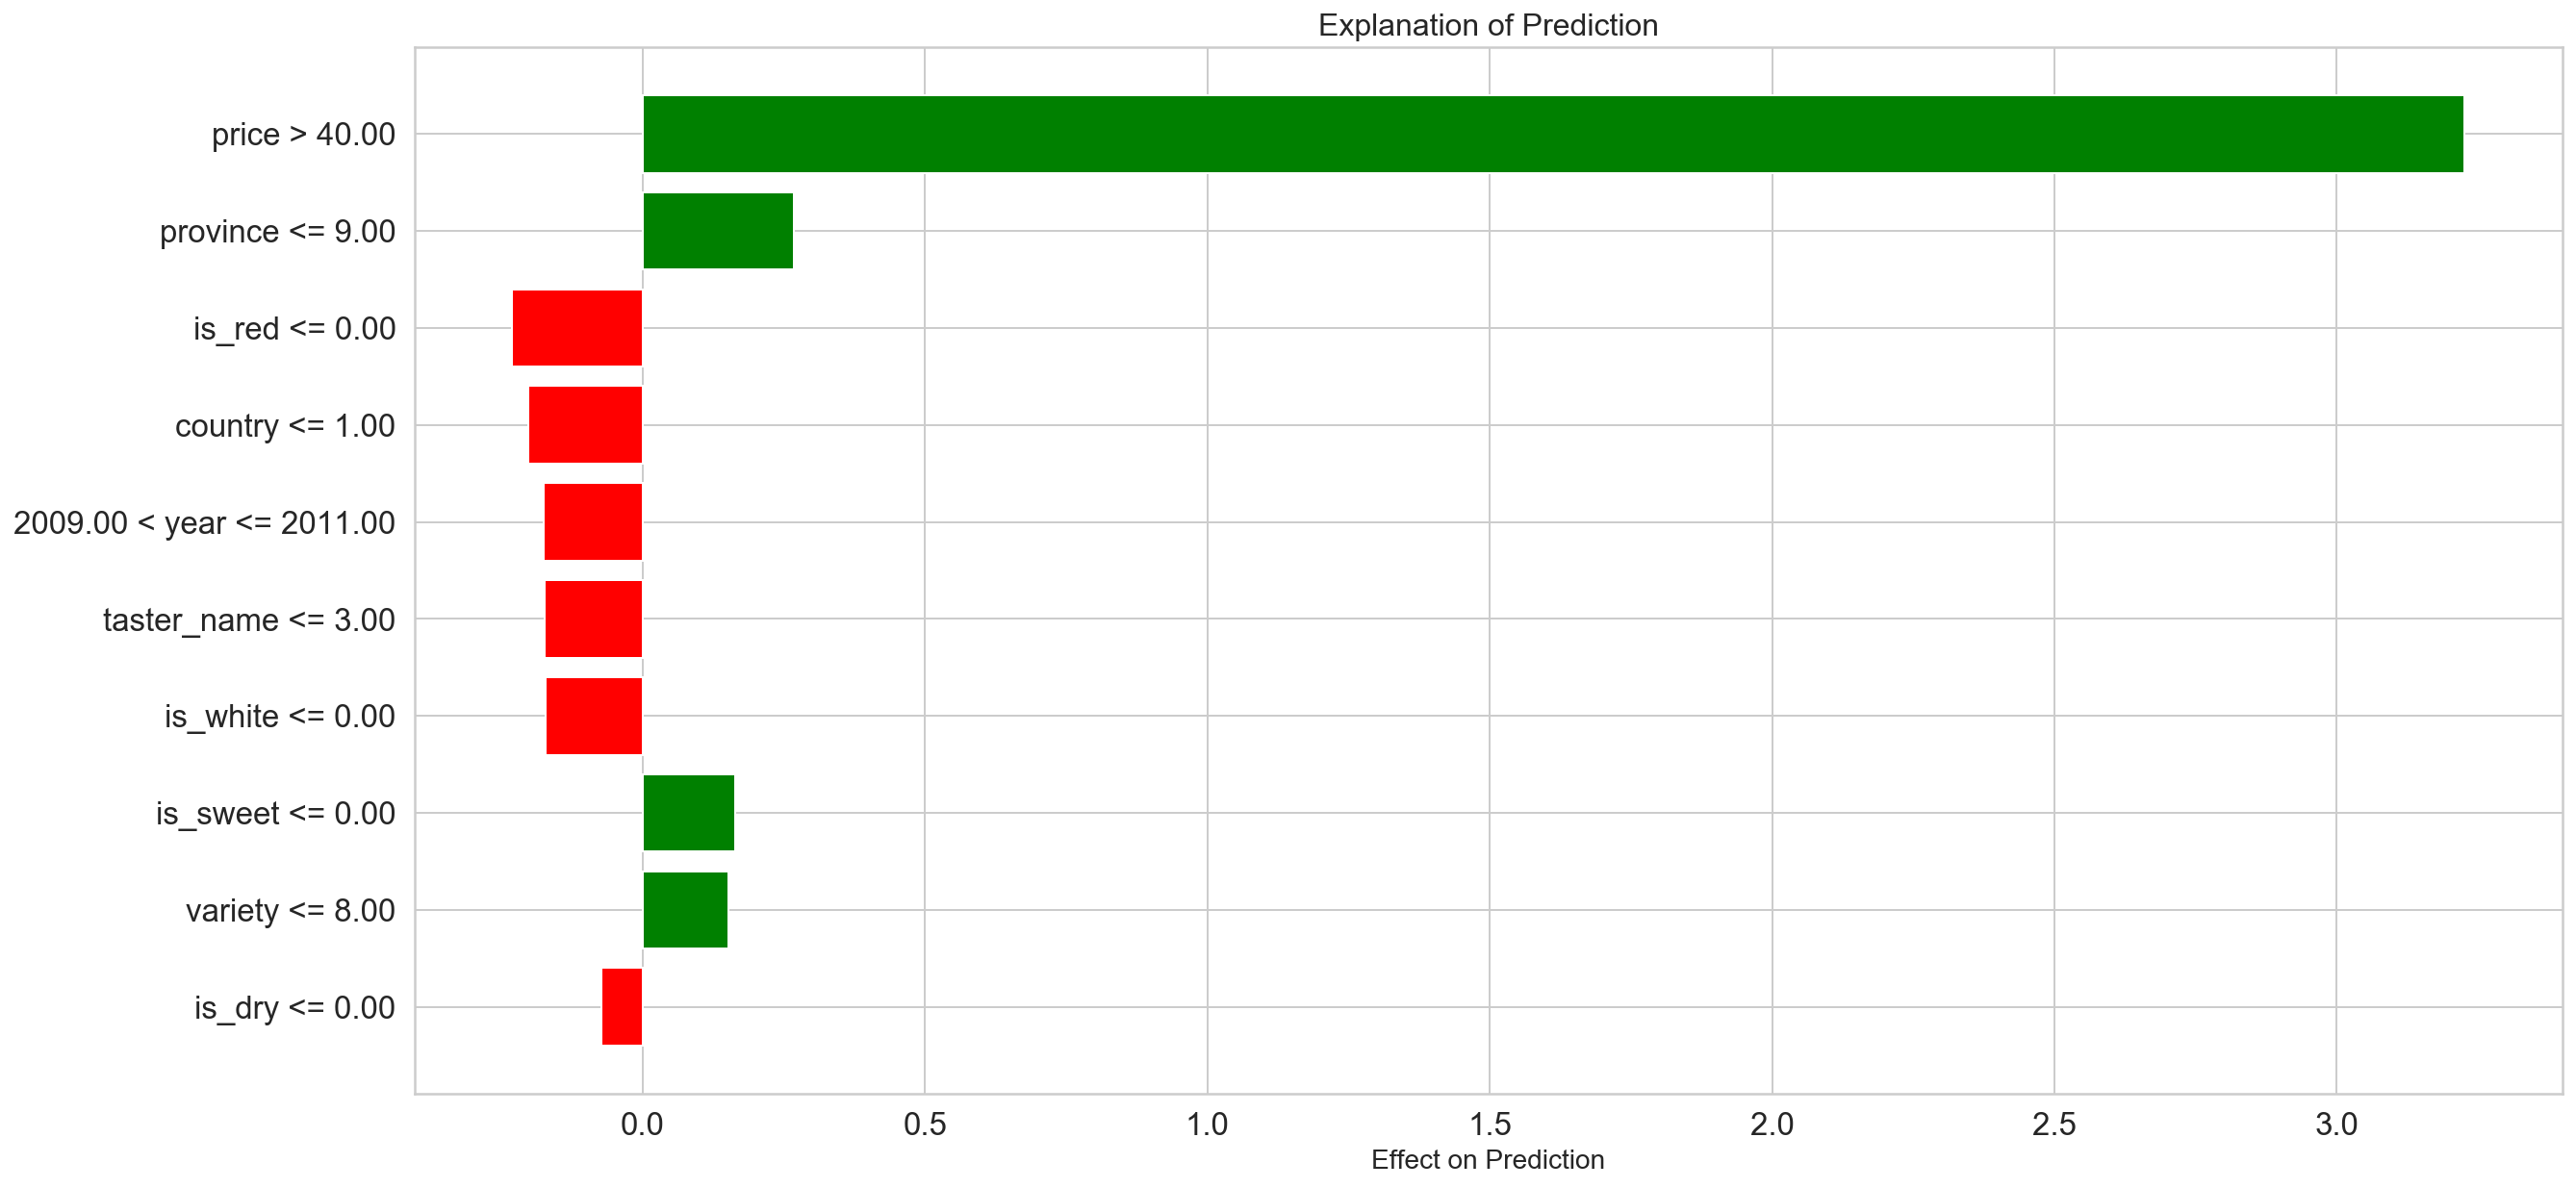

In [90]:
PlotIndividualPrediction(loaded_model, 
                         wrong,
                         residuals,
                         y_test, 
                         "IndividualPredictionExplainerWrong.png")

Prediction: [90.99943514]
Actual Value: 82


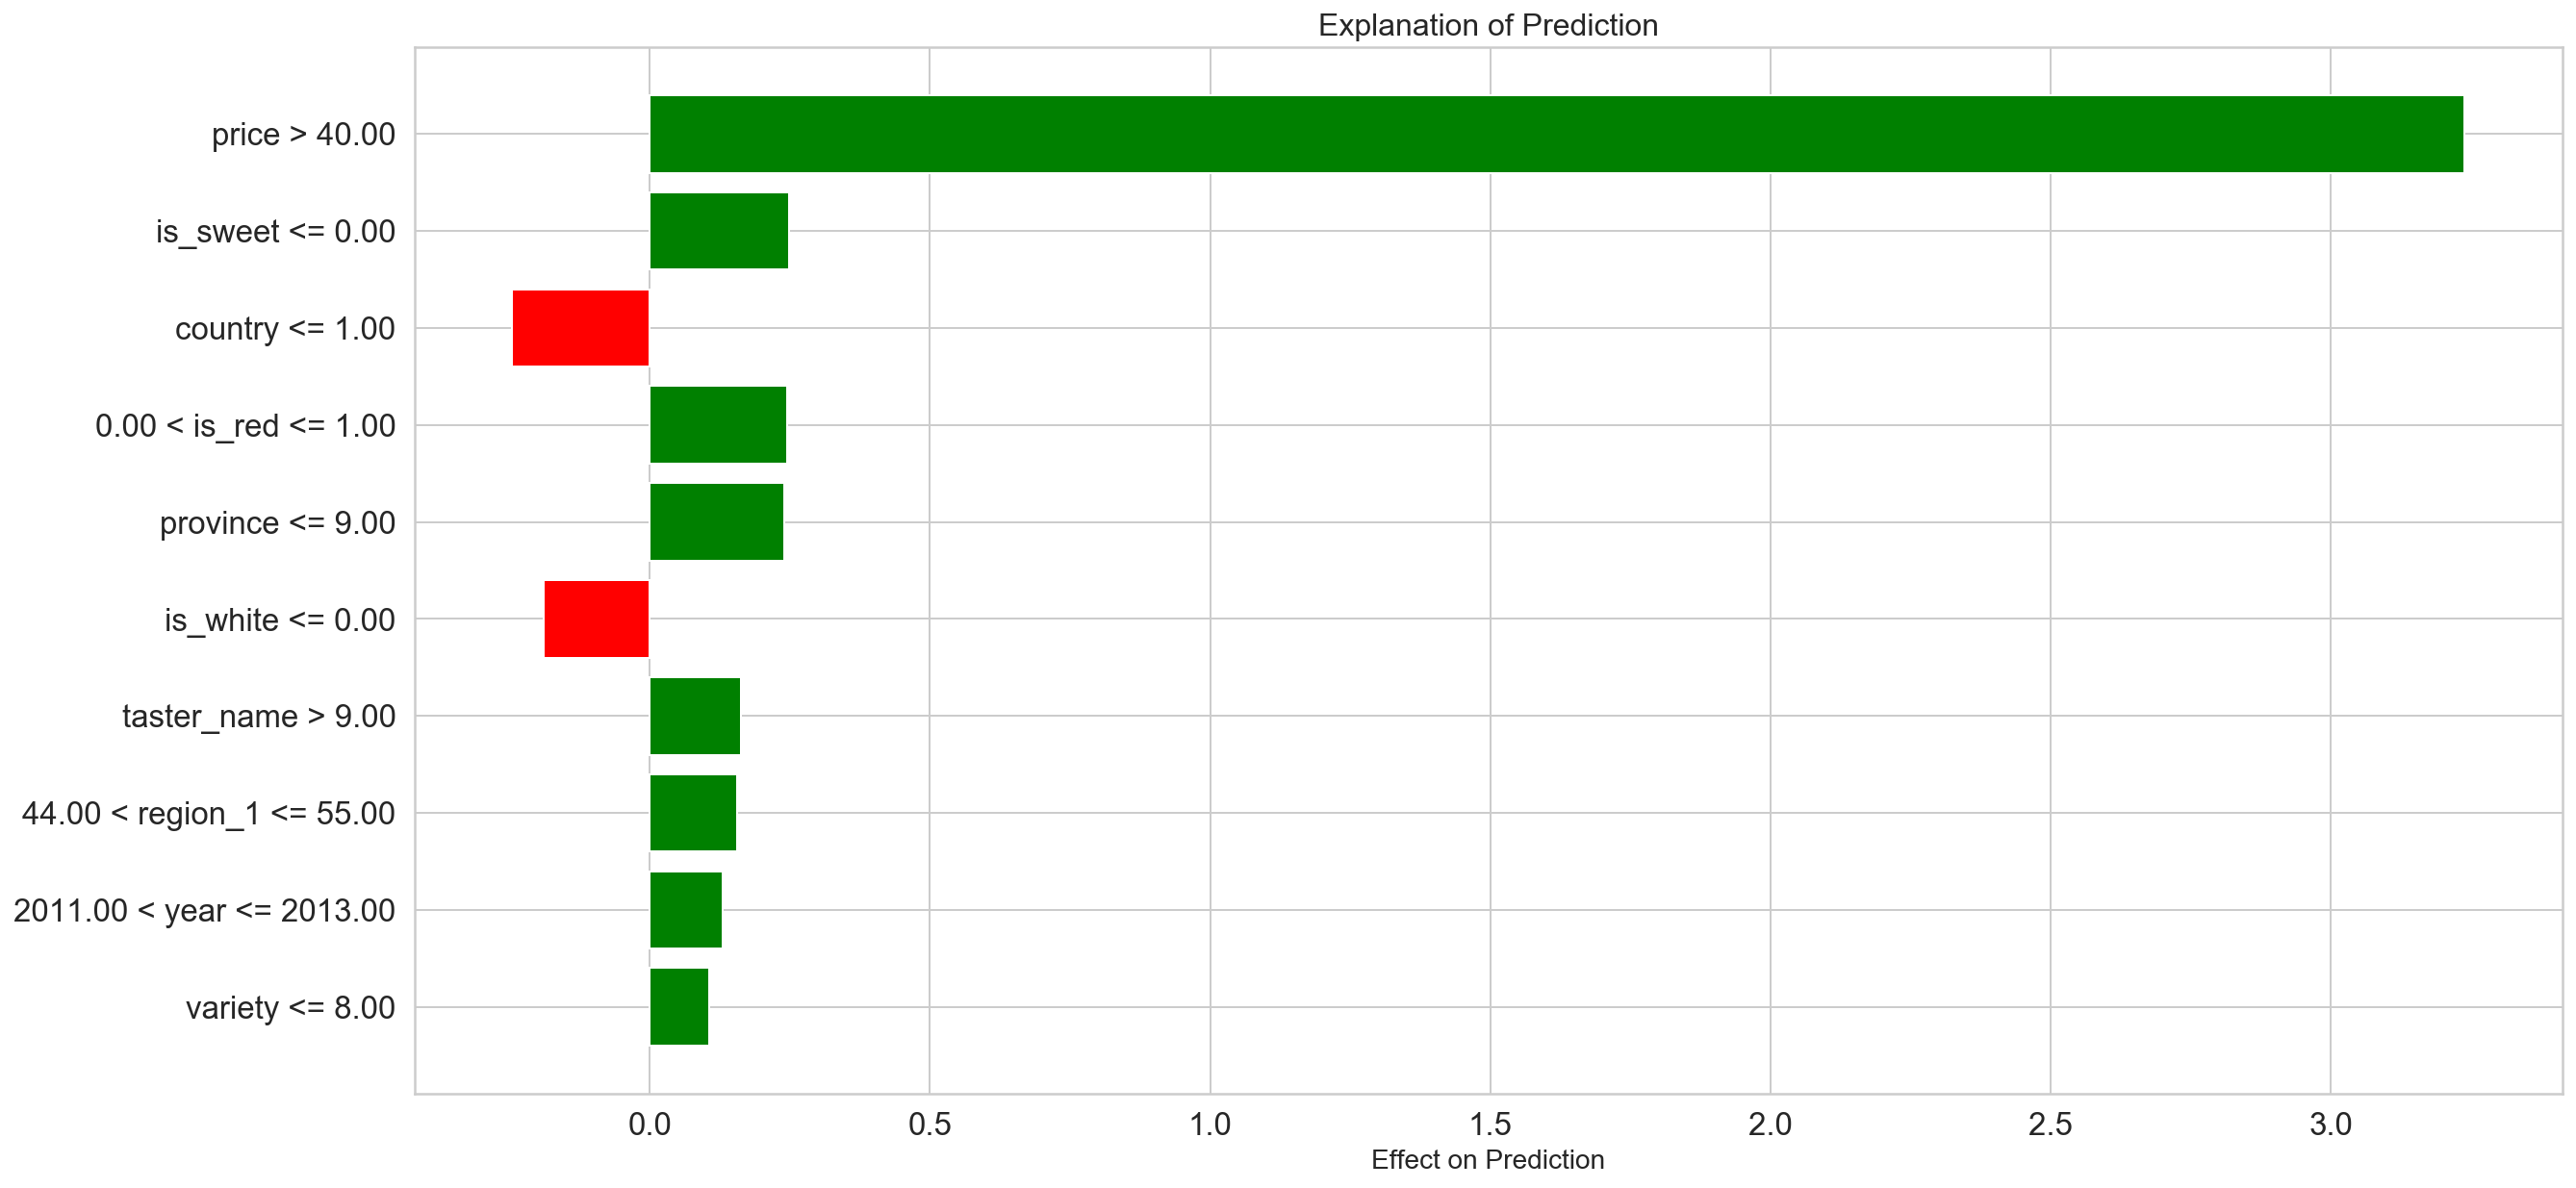

In [91]:
PlotIndividualPrediction(loaded_model, 
                         right,
                         residuals,
                         y_test, 
                         "IndividualPredictionExplainerRight.png")